In [47]:
from google_images_download import google_images_download
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from twitterscraper import query_tweets
from tpot import TPOTRegressor

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# Lambda School Data Science Unit 4 Sprint Challenge 4

## RNNs, CNNs, AutoML, and more...

In this sprint challenge, you'll explore some of the cutting edge of Data Science.

*Caution* - these approaches can be pretty heavy computationally. All problems were designed so that you should be able to achieve results within at most 5-10 minutes of runtime on Colab or a comparable environment. If something is running longer, doublecheck your approach!

## Part 1 - RNNs

Use an RNN to fit a simple classification model on tweets to distinguish from tweets from Austen Allred and tweets from Weird Al Yankovic.

Following is code to scrape the needed data (no API auth needed, uses [twitterscraper](https://github.com/taspinar/twitterscraper)):

In [2]:
!pip install twitterscraper -q

In [3]:
from twitterscraper import query_tweets

austen_tweets = query_tweets('from:austen', 1000)
len(austen_tweets)

INFO: queries: ['from:austen since:2006-03-21 until:2006-11-14', 'from:austen since:2006-11-14 until:2007-07-11', 'from:austen since:2007-07-11 until:2008-03-05', 'from:austen since:2008-03-05 until:2008-10-30', 'from:austen since:2008-10-30 until:2009-06-25', 'from:austen since:2009-06-25 until:2010-02-19', 'from:austen since:2010-02-19 until:2010-10-15', 'from:austen since:2010-10-15 until:2011-06-11', 'from:austen since:2011-06-11 until:2012-02-04', 'from:austen since:2012-02-04 until:2012-09-30', 'from:austen since:2012-09-30 until:2013-05-26', 'from:austen since:2013-05-26 until:2014-01-20', 'from:austen since:2014-01-20 until:2014-09-15', 'from:austen since:2014-09-15 until:2015-05-12', 'from:austen since:2015-05-12 until:2016-01-05', 'from:austen since:2016-01-05 until:2016-08-31', 'from:austen since:2016-08-31 until:2017-04-26', 'from:austen since:2017-04-26 until:2017-12-21', 'from:austen since:2017-12-21 until:2018-08-16', 'from:austen since:2018-08-16 until:2019-04-12']
INFO

181

In [4]:
austen_tweets[0].text

'I love love love working with great people.pic.twitter.com/fCKOm6Vl'

In [5]:
al_tweets = query_tweets('from:AlYankovic', 1000)
len(al_tweets)

INFO: queries: ['from:AlYankovic since:2006-03-21 until:2006-11-14', 'from:AlYankovic since:2006-11-14 until:2007-07-11', 'from:AlYankovic since:2007-07-11 until:2008-03-05', 'from:AlYankovic since:2008-03-05 until:2008-10-30', 'from:AlYankovic since:2008-10-30 until:2009-06-25', 'from:AlYankovic since:2009-06-25 until:2010-02-19', 'from:AlYankovic since:2010-02-19 until:2010-10-15', 'from:AlYankovic since:2010-10-15 until:2011-06-11', 'from:AlYankovic since:2011-06-11 until:2012-02-04', 'from:AlYankovic since:2012-02-04 until:2012-09-30', 'from:AlYankovic since:2012-09-30 until:2013-05-26', 'from:AlYankovic since:2013-05-26 until:2014-01-20', 'from:AlYankovic since:2014-01-20 until:2014-09-15', 'from:AlYankovic since:2014-09-15 until:2015-05-12', 'from:AlYankovic since:2015-05-12 until:2016-01-05', 'from:AlYankovic since:2016-01-05 until:2016-08-31', 'from:AlYankovic since:2016-08-31 until:2017-04-26', 'from:AlYankovic since:2017-04-26 until:2017-12-21', 'from:AlYankovic since:2017-12

960

In [6]:
al_tweets[0].text

'Well well well... look what just showed up on my doorstep! http://twitpic.com/59mi2c'

In [7]:
len(austen_tweets + al_tweets)

1141

Your tasks:

- Encode the characters to a sequence of integers for the model
- Get the data into the appropriate shape/format, including labels and a train/test split
- Use Keras to fit a predictive model, classifying tweets as being from Austen versus Weird Al
- Report your overall score and accuracy

For reference, the [Keras IMDB sentiment classification example](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py) will be useful, as well the RNN code we used in class.

*Note* - focus on getting a running model, not on maxing accuracy with extreme data size or epoch numbers. Only revisit and push accuracy if you get everything else done!

In [62]:
# encode characters as sequence of integers
tweets_text = ''
for twt in austen_tweets:
    tweets_text += twt.text
for twt in al_tweets:
    tweets_text += twt.text
    
chars = list(set(tweets_text))

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

austen_encode = []
for twt in austen_tweets:
    austen_encode.append([char_indices[char] for char in twt.text])
al_encode = []
for twt in al_tweets:
    al_encode.append([char_indices[char] for char in twt.text])

In [65]:
# get data into proper format (positive class = austen's tweets)
df_austen = pd.DataFrame({'enc' : [e for e in austen_encode], 'target' : [1] * len(austen_tweets)})
df_al = pd.DataFrame({'enc' : [e for e in al_encode], 'target' : [0] * len(al_tweets)})
df = pd.concat([df_austen, df_al], ignore_index=True)

# train test split
max_tweet_length = 280
X = sequence.pad_sequences(df.enc, maxlen=max_tweet_length)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   stratify=y)

In [68]:
# keras predictive model
model = Sequential()
model.add(Embedding(top_words, 30, input_length=max_tweet_length))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 280, 30)           150000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 166,251
Trainable params: 166,251
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100)

Train on 912 samples, validate on 229 samples
Epoch 1/10
912/912 [==============================] - 3s 3ms/step - loss: 0.2057 - acc: 0.9353 - val_loss: 0.2596 - val_acc: 0.8865
Epoch 2/10
912/912 [==============================] - 3s 3ms/step - loss: 0.2006 - acc: 0.9342 - val_loss: 0.2692 - val_acc: 0.8908
Epoch 3/10
912/912 [==============================] - 3s 3ms/step - loss: 0.1956 - acc: 0.9276 - val_loss: 0.2620 - val_acc: 0.8908
Epoch 4/10
912/912 [==============================] - 3s 3ms/step - loss: 0.1808 - acc: 0.9397 - val_loss: 0.2495 - val_acc: 0.8952
Epoch 5/10
912/912 [==============================] - 3s 3ms/step - loss: 0.1830 - acc: 0.9375 - val_loss: 0.2448 - val_acc: 0.8952
Epoch 6/10
912/912 [==============================] - 3s 3ms/step - loss: 0.1726 - acc: 0.9408 - val_loss: 0.2741 - val_acc: 0.8908
Epoch 7/10
912/912 [==============================] - 3s 3ms/step - loss: 0.1764 - acc: 0.9375 - val_loss: 0.2451 - val_acc: 0.9039
Epoch 8/10
912/912 [==========

In [75]:
# overall score and accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 90.83%


Conclusion - RNN runs, and gives pretty decent improvement over a naive "It's Al!" model. To *really* improve the model, more playing with parameters, and just getting more data (particularly Austen tweets), would help. Also - RNN may well not be the best approach here, but it is at least a valid one.

## Part 2- CNNs

Time to play "find the frog!" Use Keras and ResNet50 to detect which of the following images contain frogs:

In [8]:
!pip install google_images_download -q

In [9]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal pond", "limit": 5, "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal pond
Evaluating...
Starting Download...
Image URL: https://www.enchantedlearning.com/pgifs/Pondanimals.GIF
Completed Image ====> 1. pondanimals.gif
Image URL: https://i.ytimg.com/vi/NCbu0TND9vE/hqdefault.jpg
Completed Image ====> 2. hqdefault.jpg
Image URL: https://pklifescience.com/staticfiles/articles/images/PKLS4116_inline.png
Completed Image ====> 3. pkls4116_inline.png
Image URL: https://pixnio.com/free-images/fauna-animals/reptiles-and-amphibians/alligators-and-crocodiles-pictures/alligator-animal-on-pond.jpg
Completed Image ====> 4. alligator-animal-on-pond.jpg
Image URL: https://www.nwf.org/-/media/NEW-WEBSITE/Programs/Garden-for-Wildlife/amphibian_bronze-frog_Julia-Bartosh_400x267.ashx
Completed Image ====> 5. amphibian_bronze-frog_julia-bartosh_400x267.ash

Errors: 0



At time of writing at least a few do, but since the Internet changes - it is possible your 5 won't. You can easily verify yourself, and (once you have working code) increase the number of images you pull to be more sure of getting a frog. Your goal is to validly run ResNet50 on the input images - don't worry about tuning or improving the model.

*Hint* - ResNet 50 doesn't just return "frog". The three labels it has for frogs are: `bullfrog, tree frog, tailed frog`

*Stretch goal* - also check for fish.

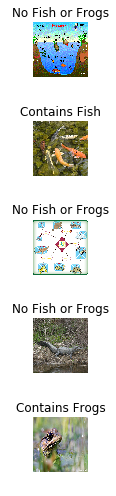

In [37]:
def check_pond_animals(img_paths, confidence=0.1):
    """Checks for frogs and fish"""
    # load resnet50
    model = ResNet50(weights='imagenet')
    
    fig, ax = plt.subplots(nrows=len(img_paths), figsize=(10*len(img_paths), 7))
    
    for i, img_path in enumerate(img_paths):
        frogs, fish = False, False
        # load the image
        img = image.load_img(img_path, target_size=(224, 224))
        # preprocess image for prediction
        X = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
        preds = decode_predictions(model.predict(X), top=3)[0]
        
        # see if images have fish, frogs or both
        if any(['fish' in pred[1] for pred in preds]):
            fish = True
        if any(['frog' in pred[1] for pred in preds]):
            frogs = True
            
        if fish and frogs:
            ax[i].set_title('Contains Fish and Frogs')
        elif fish:
            ax[i].set_title('Contains Fish')
        elif frogs:
            ax[i].set_title('Contains Frogs')
        else:
            ax[i].set_title('No Fish or Frogs')
        
        ax[i].imshow(img)
        ax[i].axis('off')
    
    plt.tight_layout()
    plt.show()

check_pond_animals(absolute_image_paths['animal pond'])

## Part 3 - AutoML

Use [TPOT](https://github.com/EpistasisLab/tpot) to fit a predictive model for the King County housing data, with `price` as the target output variable.

In [10]:
!pip install tpot -q

In [11]:
!wget https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv

--2019-04-12 11:09:46--  https://raw.githubusercontent.com/ryanleeallred/datasets/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.116.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.116.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  12.2MB/s    in 0.2s    

2019-04-12 11:09:46 (12.2 MB/s) - ‘kc_house_data.csv’ saved [2515206/2515206]



In [12]:
!head kc_house_data.csv

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000
"1954400510","20150218T000000",510000,3,2,1680,8080,"1",0,0,3,8,1680,0,1987,0,"98074",47.6168,-122.045,1800,7503
"7237550310","20140512T000000",1.225e+006,4,4.5,5420,101930,"1",0,0,3,11,3890,1530,2001,0,"98053",47.6561,-122.005,4760,101930
"1321400060","20140627T000000",257500,3,2.25,1715,6819,"2",0,0,3,7,1715,0,1995,0,"98003",47.3097,-122.327,2238,6819
"2

As with previous questions, your goal is to run TPOT and successfully run and report error at the end.  Also, in the interest of time, feel free to choose small `generation=1` and `population_size=10` parameters so your pipeline runs efficiently and you are able to iterate and test.

*Hint* - you'll have to drop and/or type coerce at least a few variables to get things working. It's fine to err on the side of dropping to get things running, as long as you still get a valid model with reasonable predictive power.

In [38]:
data = pd.read_csv('kc_house_data.csv')

In [41]:
X = data.drop(columns=['id', 'date', 'price'])
y = data.price

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)

In [44]:
tpot = TPOTRegressor(generations=5, population_size=10, verbosity=2)
tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: -20446824148.05599
Generation 2 - Current best internal CV score: -20446824148.05599
Generation 3 - Current best internal CV score: -18237041061.474293
Generation 4 - Current best internal CV score: -18237041061.474293
Generation 5 - Current best internal CV score: -18216244666.655083

Best pipeline: LassoLarsCV(VarianceThreshold(PCA(LinearSVR(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=100, nthread=1, subsample=0.15000000000000002), C=0.1, dual=False, epsilon=0.01, loss=squared_epsilon_insensitive, tol=0.001), iterated_power=7, svd_solver=randomized), threshold=0.0001), normalize=True)


TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
       disable_update_check=False, early_stop=None, generations=5,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=10,
       random_state=None, scoring=None, subsample=1.0, use_dask=False,
       verbosity=2, warm_start=False)

In [45]:
print('Test Score %.2f' % tpot.score(X_test, y_test))

Test Score -13920826116.80


## Part 4 - More...

Answer the following questions, with a target audience of a fellow Data Scientist:

- What do you consider your strongest area, as a Data Scientist?
- What area of Data Science would you most like to learn more about, and why?
- Where do you think Data Science will be in 5 years?

A few sentences per answer is fine - only elaborate if time allows.

#### What do you consider your strongest area, as a Data Scientist?

Descriptive statistics and basic predictive modeling. I have been working with similar concepts over the past 4 years or so, from my undergraduate econometrics courses to my recent professional experience.

#### What area of Data Science would you most like to learn more about, and why?

Natural Language Processing. NLP increasingly offers machines a fluid interface with human communication patterns.

#### Where do you think Data Science will be in 5 years?

I think there will be increased emphasis on both AutoML and interpretability. To some extent, the two go hand in hand.

AutoML makes data science increasingly efficient. I suspect, however, that many real world use cases also derive value from the interpretation of insights gained in DS/ML modeling.

Thank you for your hard work, and congratulations! You've learned a lot, and should proudly call yourself a Data Scientist.